<a href="https://colab.research.google.com/github/harim061/CNN/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch import nn

class ResBlock(nn.Module):
	def __init__(self, block):
		super().__init__()
		self.block = block
	def forward(self, x):
		return self.block(x) + x #f(x) + x

- self.block(x)는 입력 x가 block을 통과한 후의 출력값 = F(x)
- 원래의 입력 x와 F(x)를 더하여 최종 출력값을 생성 -> H(x) = F(x) + x

# CNN에 넣기

In [2]:
class Conv6(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()
    self.name = 'conv6'
    self.model = nn.Sequential(

        # nn.Conv2d(입력채널수, 출력채널수(32개 필터), 커널(필터)크기, 스트라이드, 패딩)
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Flatten(),
        nn.Linear(32*32*32, 256),
        nn.ReLU(),
        nn.Linear(256, 10)

    )
  def forward(self, x):
    return self.model(x)

In [3]:
# 몇몇 레이어를 residual block으로 묶기
class Conv6Res(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()
    self.name = 'conv6res'
    self.model = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        ResBlock(
            nn.Sequential(
                nn.Conv2d(32, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.ReLU()
            )
        ),

        ResBlock(
            nn.Sequential(
                nn.Conv2d(32, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
            )
        ),
        nn.Flatten(),
        nn.Linear(32*32*32, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )
  def forward(self, x):
    return self.model(x)

# CIFAR10 데이터셋에 대해 트레이닝하여 비교

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os

# Downloading the CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
cifar_tr = datasets.CIFAR10(root=os.getcwd(), train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(root=os.getcwd(), train=False, download=True, transform=transform)


# Split training data into train set and validation set
def split_train_valid(dataset, valid_ratio=0.1):
  data_size = len(dataset)
  indices = list(range(data_size))
  np.random.seed(1)
  np.random.shuffle(indices)

  split_point = int(np.floor(valid_ratio*data_size))
  val_index, train_index = indices[:split_point-1], indices[split_point:]

  train = torch.utils.data.Subset(dataset, train_index)
  valid = torch.utils.data.Subset(dataset, val_index)

  return train, valid

cifar_train, cifar_valid = split_train_valid(dataset=cifar_tr)

# Make DataLoaders for train/validation/test sets
cifar_loaders = [DataLoader(dataset=d, batch_size=32, shuffle=True, drop_last=True) for d in [cifar_train, cifar_valid, cifar_test]]

# Define model to train
model = Conv6()

# Define loss function and optimizer
# 손실 함수 정의
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use GPU if available (CPU if not)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
print("===== Train Start =====")
num_epochs = 40
history = {"train_loss": [], "train_acc": [], "valid_loss":[], "valid_acc":[]} # record of loss and accuracy in each epoch for plotting later
for epoch in range(num_epochs):
	train_loss, train_acc = 0, 0
	model.train()
	for (x, y) in cifar_loaders[0]: #cifar_loaders[0] is train set DataLoader
		x = x.to(device)
		y = y.to(device)

		y_hat = model(x)
		loss_val = loss_fn(y_hat, y)

		optimizer.zero_grad()
		loss_val.backward()
		optimizer.step()

		train_loss += loss_val.to("cpu").item()
		train_acc += (y_hat.argmax(1)==y).type(torch.float).to('cpu').mean().item()

	train_loss /= len(cifar_loaders[0]) #len(DataLoader) is batch size (ie, 128)
	train_acc /= len(cifar_loaders[0])
	history["train_loss"].append(train_loss)
	history["train_acc"].append(train_acc)

	# Evaluate model on validation set
	valid_loss, valid_acc = 0, 0
	model.eval()
	with torch.no_grad():
		for (x, y) in cifar_loaders[1]: # Validation set DataLoader
			x = x.to(device)
			y = y.to(device)

			y_hat = model(x)
			loss_val = loss_fn(y_hat, y)

			valid_loss += loss_val.to('cpu').item()
			valid_acc += (y_hat.argmax(1)==y).type(torch.float).to('cpu').mean().item()

	valid_loss /= len(cifar_loaders[1]) #len(DataLoader) is batch size
	valid_acc /= len(cifar_loaders[1])
	history["valid_loss"].append(valid_loss)
	history["valid_acc"].append(valid_acc)

	if epoch % 5 == 0:
	  print(f"Epoch: {epoch}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}")

# Test the model on the test set
print("===== Test Start =====")
test_loss, test_acc = 0, 0
model.eval()
with torch.no_grad():
    for (x, y) in cifar_loaders[2]:
        x = x.to(device)
        y = y.to(device)

        y_hat = model(x)
        loss_val = loss_fn(y_hat, y)

        test_loss += loss_val.to('cpu').item()
        test_acc += (y_hat.argmax(1)==y).type(torch.float).to('cpu').mean().item()

test_loss /= len(cifar_loaders[2])
test_acc /= len(cifar_loaders[2])
print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>6f}")

100%|██████████| 170498071/170498071 [00:01<00:00, 95778879.11it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
===== Train Start =====
Epoch: 0, train loss: 1.488156, train acc: 0.477396, valid loss: 1.227321, valid acc: 0.563902


KeyboardInterrupt: ignored

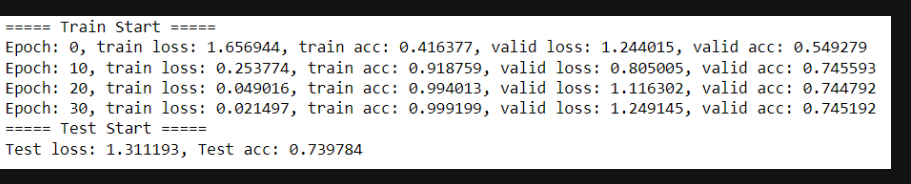

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os

# Downloading the CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
cifar_tr = datasets.CIFAR10(root=os.getcwd(), train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(root=os.getcwd(), train=False, download=True, transform=transform)


# Split training data into train set and validation set
def split_train_valid(dataset, valid_ratio=0.1):
  data_size = len(dataset)
  indices = list(range(data_size))
  np.random.seed(1)
  np.random.shuffle(indices)

  split_point = int(np.floor(valid_ratio*data_size))
  val_index, train_index = indices[:split_point-1], indices[split_point:]

  train = torch.utils.data.Subset(dataset, train_index)
  valid = torch.utils.data.Subset(dataset, val_index)

  return train, valid

cifar_train, cifar_valid = split_train_valid(dataset=cifar_tr)

# Make DataLoaders for train/validation/test sets
cifar_loaders = [DataLoader(dataset=d, batch_size=32, shuffle=True, drop_last=True) for d in [cifar_train, cifar_valid, cifar_test]]

# Define model to train
model = Conv6Res()

# Define loss function and optimizer
# 손실 함수 정의
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use GPU if available (CPU if not)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
print("===== Train Start =====")
num_epochs = 40
history = {"train_loss": [], "train_acc": [], "valid_loss":[], "valid_acc":[]} # record of loss and accuracy in each epoch for plotting later
for epoch in range(num_epochs):
	train_loss, train_acc = 0, 0
	model.train()
	for (x, y) in cifar_loaders[0]: #cifar_loaders[0] is train set DataLoader
		x = x.to(device)
		y = y.to(device)

		y_hat = model(x)
		loss_val = loss_fn(y_hat, y)

		optimizer.zero_grad()
		loss_val.backward()
		optimizer.step()

		train_loss += loss_val.to("cpu").item()
		train_acc += (y_hat.argmax(1)==y).type(torch.float).to('cpu').mean().item()

	train_loss /= len(cifar_loaders[0]) #len(DataLoader) is batch size (ie, 128)
	train_acc /= len(cifar_loaders[0])
	history["train_loss"].append(train_loss)
	history["train_acc"].append(train_acc)

	# Evaluate model on validation set
	valid_loss, valid_acc = 0, 0
	model.eval()
	with torch.no_grad():
		for (x, y) in cifar_loaders[1]: # Validation set DataLoader
			x = x.to(device)
			y = y.to(device)

			y_hat = model(x)
			loss_val = loss_fn(y_hat, y)

			valid_loss += loss_val.to('cpu').item()
			valid_acc += (y_hat.argmax(1)==y).type(torch.float).to('cpu').mean().item()

	valid_loss /= len(cifar_loaders[1]) #len(DataLoader) is batch size
	valid_acc /= len(cifar_loaders[1])
	history["valid_loss"].append(valid_loss)
	history["valid_acc"].append(valid_acc)

	if epoch % 10 == 0:
	  print(f"Epoch: {epoch}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}")

# Test the model on the test set
print("===== Test Start =====")
test_loss, test_acc = 0, 0
model.eval()
with torch.no_grad():
    for (x, y) in cifar_loaders[2]:
        x = x.to(device)
        y = y.to(device)

        y_hat = model(x)
        loss_val = loss_fn(y_hat, y)

        test_loss += loss_val.to('cpu').item()
        test_acc += (y_hat.argmax(1)==y).type(torch.float).to('cpu').mean().item()

test_loss /= len(cifar_loaders[2])
test_acc /= len(cifar_loaders[2])
print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>6f}")

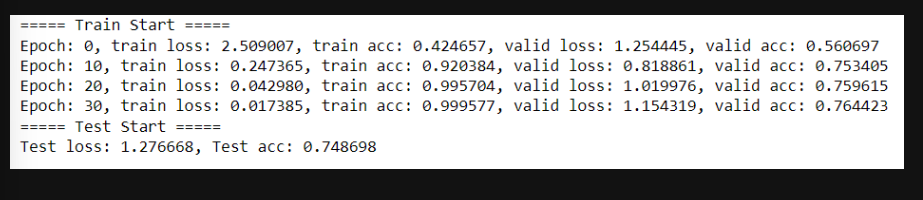

- 두 모델의 accuracy는 별 차이 없지만, residual block은 뉴럴 네트워크의 레이어 갯수가 점점 많아지면서 오히려 performance가 저하 되는 'degradation'현상을 막아주는 것이 주 역할이므로 레이어가 더 많은 deeper 뉴럴 네트워크들에서 residual block의 효과를 봄